In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings("ignore")

In [9]:
train_path = "E:\\Lung Cancer\\chest_xray\\train"
val_path = "E:\\Lung Cancer\\chest_xray\\val"
test_path = "E:\\Lung Cancer\\chest_xray\\test"

In [10]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)


{'NORMAL': 1341, 'PNEUMONIA': 3875} 

 {'NORMAL': 8, 'PNEUMONIA': 8} 

 {'NORMAL': 234, 'PNEUMONIA': 390}


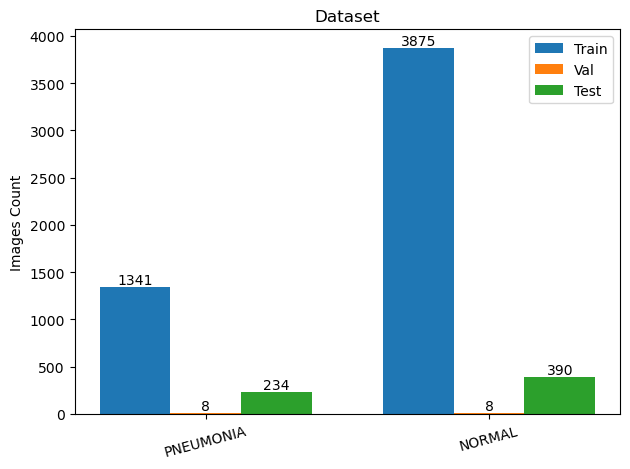

In [11]:
labels = ['PNEUMONIA', 'NORMAL']

train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()
plt.show()


In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)  
BATCH_SIZE = 32 

train_dir = train_path
validation_dir = val_path
test_dir=test_path

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest' 
)

validation_datagen = ImageDataGenerator(rescale=1./255)  
testing_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True, 
    fill_mode='nearest'  
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  
)

testing_generator=testing_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


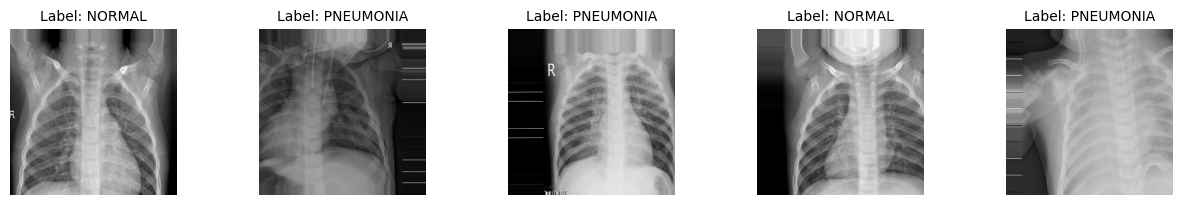

In [23]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))  
    fig.subplots_adjust(wspace=0.5)  

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  
        axs[i].axis('off')

    plt.show()


sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:5], sample_labels[:5], train_data.class_indices)

In [47]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2  
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if using one-hot encoded labels
              metrics=['accuracy'])

model.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [49]:
steps_per_epoch_train = train_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch_train += 1

steps_per_epoch_validation = validation_generator.samples // BATCH_SIZE
if validation_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch_validation += 1

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

loss, accuracy = model.evaluate(validation_generator, steps=steps_per_epoch_validation)
print('Validation Accuracy: {:.2f}%'.format(accuracy * 100))


Epoch 1/20
163/163 [==============================] - 678s 4s/step - loss: 0.2160 - accuracy: 0.9084 - val_loss: 0.5461 - val_accuracy: 0.7500
Epoch 2/20
163/163 [==============================] - 686s 4s/step - loss: 0.2126 - accuracy: 0.9135 - val_loss: 0.7070 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 695s 4s/step - loss: 0.1929 - accuracy: 0.9220 - val_loss: 0.5339 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - 679s 4s/step - loss: 0.1945 - accuracy: 0.9185 - val_loss: 0.3844 - val_accuracy: 0.7500
Epoch 5/20
163/163 [==============================] - 677s 4s/step - loss: 0.1902 - accuracy: 0.9275 - val_loss: 0.4088 - val_accuracy: 0.7500
Epoch 6/20
163/163 [==============================] - 673s 4s/step - loss: 0.1779 - accuracy: 0.9317 - val_loss: 0.3129 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 672s 4s/step - loss: 0.1679 - accuracy: 0.9342 - val_loss: 0.3891 - val_accuracy: 0.8125